## Abstract

By unveiling the latent variables that can generate observed properties of objects is one of the most fundamental issues in unsupervised learning. However, one of the crucial problems of unsupervised learning algorithms is to detect the latent structure. In K-means problem for example, we need to determine the number of clusters. One classic way is by performing model selection, while the other way is to use a Bayesian nonparametric method. One important method of Bayesian nonparametric method is the Indian buffet process (IBP), which is a stochastic process that provides a probability distribution over equivalence classes of binary matrices of bounded rows and potentially infinite columns. 

In this report, we first implement the Indian buffet process by Gibbs sampling and Metropolis-Hasting algorithm in python. For improvement in efficiency, we perform matrix calculation optimization indicated from Griffiths & Ghahramani's complete paper[1] and utilize parallel programming, JIT and Cython to decrease the computation duration. Moreover, we use check the validity and effectiveness of our acceleration and optimization.

In [17]:
import math
import numpy as np
import time
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    print('%s: %.1f' % (fs[0].__name__, 1.0))  
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

## 1. Introduction: Indian Buffet Process

Indian restaurants in London offer buffets with an apparently infinite number of dishes. Indian buffet process (IBP) is a distribution over infinite binary matrices, specifying how customers (objects) choose dishes (features).

N customers enter a restaurant one after another. Each customer is exposed to a buffet consisting of infinitely many dishes arranged in a line. The first customer starts at the left of the buffet and takes a serving from each dish, stopping after certain number of dishes which follows a Poisson($\alpha$) distribution. The ith customer moves along the buffet, sampling dishes based on their "popularity". The ith customer takes dish k with probability $\frac{m_k}{i}$, where $m_k$ is the number of previous customers who have sampled that dish. Having reached the end of all previous sampled dishes, the ith customer then tries a Poisson($\frac{\alpha}{i}$) number of new dishes. In conclusion, except the first customer(object), all the following customers(objects)'s choice can be divided into two parts. The first part depends on all the previous information and can be treated as Bernoulli trials, while the second part goes beyond the number of dishes from before and the number of "new dishes" follows a Poisson distribution with a new rate of $\frac{\alpha}{i}$.

We can indicate which customers chose which dishes using a binary matrix Z with N rows and infinitely many columns, where $z_{ik}$ = 1 if the ith customer sampled the kth dish. 

<img src="IBPfigure6.png">

## 2. Algorithm Implementation

### 2.1 Data

#### 2.1.1 Data structure



* Feature binary matrix Z with entry either 0 or 1

* Number of new features $K_{new}$ having a Poisson distribution

* Parameter $\alpha$: $K_{new}$'s distribution parameter

* $\sigma^2_X$: Covariance of Gaussian Distribution on x

* $\sigma^2_A$: Covariance of Gaussian Distribution prior on A


#### 2.1.2 Data Simulation

To implement the example in the paper before optimization, we have followed the quotation below from the original paper to generate data. 

"As a first demonstration of the ability of this algorithm to recover the latent structure responsible
for having generated observed data, we applied the Gibbs sampler for the infinite linear-Gaussian
model to a simulated data set consisting of 100 6×6 images, each generated by randomly assigning
a feature to each image to a class with probability 0.5, and taking a linear combination of the
weights associated with features to which the images were assigned (a similar data set was used by
Ghahramani, 1995).  The non-zero elements of A were all equal to 1.0, and σX was set to
0.5, introducing a large amount of noise. The data were generated from a model with K+ = 4 "

The "A" is constructed based on the example in a more complete paper by the same authors we find called "The Indian Buffet Process: An Introduction and Review" (Griffiths&Ghahramani, 2011). We have used this as a supplement to the given paper for enhancing our understanding of IBP. We have also used a trick in calculating the inverse as described in the paper when we imlement IBP later in this report.

In [43]:
%%file scripts/data_initialization.py
import numpy as np
np.random.seed(124)
N = 100 
K_plus = 4 
D = 36 
sigmaX = 0.5
sigmaA = 0.5
# Simulated data
A = np.array(( 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, \
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0,1, 1, 1,0, 0, 0,  1, 0, 1, 0, 0, 0, 1, 1, 1,    \
             1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0,0, 0, 0, 0, 0,0 ,0, 0, \
             0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,0, 0, 0, 0,1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)).reshape(4, D)

Z_zero = np.zeros((N, K_plus))
X = np.zeros((N, D))
I = np.identity(D) * sigmaX

for i in range(N):
    Z_zero[i,:] = (np.random.uniform(0,1,K_plus) > .5).astype(int)
    while (np.sum(Z_zero[i,:]) == 0):
        Z_zero[i,:] = (np.random.uniform(0,1,K_plus) > .5).astype(int)
    X[i,:] = np.random.normal(0,1, (1,D)).dot(I)+Z_zero[i,:].dot(A)

np.save("data/X_initialized", X)
np.save("data/A_initialized", A)

Writing scripts/data_initialization.py


### 2.2 Algorithm for Metropolis Hastings

With the help of the derivitions and conclusions from the paper, we can directly code them and run the Gibbs sampler and Metropolis Hastings alorithm as follows.

#### 2.2.1 Indian Buffet Process
Following the logic in the introduction part, we first write a function "IBP_prior" to code this process.

#### 2.2.2 Infinite latent feature model (likelihood)

Here are some definitions excerpt from the paper that have helped us write the code:

$x_i$ is a $D$-dimensional vector of properties of an object i that is generated from a Gaussian distribution with mean $z_iA$ and covariance matrix $\Sigma X = \sigma^2_X $ I, where $z_i$ is a $K$-dimensional binary vector

A is a $K$ $\times$ $D$ matrix of weights. 

In matrix notation, E[X] = ZA. If Z is a feature matrix, this is a form of binary factor analysis. 

The distribution of X given Z, A, and $\sigma$ X is matrix Gaussian with mean ZA and covariance matrix $\sigma^2_X$ I, where I is the identity matrix. The prior on A is also matrix Gaussian, with mean 0 and covariance matrix $\sigma^2_X$ I. Integrating out A, we have:

\begin{multline}
P(X|Z,\sigma_X, \sigma_A) = \frac{1}{(2 \pi)^{ND/2} (\sigma_X)^{(N-K)D}(\sigma_A)^{KD}(|Z^TZ+\frac{\sigma_X^2}{\sigma_A^2}I|)^{D/2}}\\exp\{-\frac{1}{2\sigma_X^2}tr(X^T(I-Z(Z^TZ+\frac{\sigma_X^2}{\sigma_A^2}I)^{-1}Z^T)X)\}
\end{multline}

In [44]:
%%file scripts/original_functions.py
#prior of IBP
import math
def IBP_prior(alpha, N):
    import numpy as np
    res = np.zeros((N, 1000))

    #First person
    temp = np.random.poisson(alpha)
    if temp > 0:
        res[0,0:temp] = np.ones(temp)

    #the rest with Bernoulli + Poisson
    K_plus = temp
    for i in range(1,N):
        for j in range(K_plus):
            p = np.sum(res[0:i,j])/(i+1)
    #sample as Bernoulli with rate m_k/i
            if np.random.uniform(0,1) < p:
                res[i,j] = 1
    #The "untouched" dishes are got from poisson distribution with rate alpha/i
        temp = np.random.poisson(alpha/(i+1))
    #None zero
        if temp > 0:
    #The "new dishes", silimar logic as the very first person
            res[i, K_plus : K_plus + temp] = np.ones(temp)
    #length of new person's first few "bernoulli" choice 
            K_plus = K_plus + temp
    
    res = res[:,0:K_plus]
    return np.array((res, K_plus))

# define a log likelihood function 
def log_p_origin(X, Z, sigmaX, sigmaA, K, D, N):
    import numpy as np
    return (-1)*np.log(2*np.pi)*N*D*.5 - np.log(sigmaX)*(N-K)*D - np.log(sigmaA)*K*D - .5*D*np.log(np.linalg.det(Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K))) -.5/(sigmaX**2)*np.trace( (X.T.dot( np.identity(N)-Z.dot(np.linalg.inv(Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K)).dot(Z.T)) )).dot(X) )


# define a log likelihood function 
def log_p(X, Z, sigmaX, sigmaA, K, D, N):
    import numpy as np
    M = Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K)
    return (-1)*np.log(2*np.pi)*N*D*.5 - np.log(sigmaX)*(N-K)*D - np.log(sigmaA)*K*D - .5*D*np.log(np.linalg.det(M)) -.5/(sigmaX**2)*np.trace( (X.T.dot( np.identity(N)-Z.dot(np.linalg.inv(M).dot(Z.T)) )).dot(X) )

def calcInverse(Z,M,i,k):
    import numpy as np
    """New inverse calculation as described in Griffiths and Ghahramani(2011)"""
    M_i = M - M.dot(Z[i,:].T.dot(Z[i,:].dot(M)))/(Z[i,:].dot(M.dot(Z[i,:].T))-1)
    M = M_i - M_i.dot(Z[i,:].T.dot(Z[i,:].dot(M_i)))/(Z[i,:].dot(M_i.dot(Z[i,:].T))+1)
    Inv = M
    return Inv

Writing scripts/original_functions.py


#### 2.2.3 Gibbs Samplers and Metropolis Algorithm

With Z prior of: $P(z_{ik}\mid z_{-i,k})=\frac{n_{-i,k}}{N}$ , $\alpha$'s prior of Gamma(1,1) and k's prior of $Poisson(\frac{\alpha}{N})$

We can directly use the full conditional of Gibbs samplers for Z and $\alpha$ with:

$P(z_{ik}|X,Z_{-(i,k),},\sigma_X,\sigma_A) \propto  P(X|Z,\sigma_X, \sigma_A) P(z_{ik}=1|\textbf{z}_{-i,k}) $

$P (\alpha\mid Z) \sim Gamma(1 + K_+ , 1 + H_N )$ , where H_N = $\sum_{i=1}^N \frac{1}{i}$

For the Metropolis-Hastings part, we sample $\sigma^*_X$ from $\sigma_X+\epsilon$ where $\epsilon\sim Unif(-0.05,0.05)$. We also sample $\sigma^*_A$ from $\sigma_A+\epsilon$

The acceptence rate for X is $min\{1,\frac{P(X|Z, \sigma_X^{*}, \sigma_A)}{P(X|Z, \sigma_X,\sigma_A)}$

The acceptence rate for A is $min\{1,\frac{P(A|Z, \sigma_X, \sigma_A^{*})}{P(X|Z, \sigma_X,\sigma_A)}$


In [45]:
%%file scripts/gibbs_sampler.py
import numpy as np
import math
def Update_alpha(N,Kplus):
    Harmonic_N = 0.
    for i in range(1, N+1):
        Harmonic_N += 1.0/i
    alpha = np.random.gamma(1+Kplus, 1/(1+Harmonic_N))
    return alpha

def Update_sigmaA(X, Z, sigmaX, sigmaA, Kplus, D, N,Log_L1):
    temp_unif1 = np.random.uniform(0,1)/30
    if np.random.uniform(0,1) < .5:
        sigmaA_new = sigmaA - temp_unif1
    else:
        sigmaA_new = sigmaA + temp_unif1

    Log_L_New = log_p(X, Z, sigmaX, sigmaA_new, Kplus, D, N)
    sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))
    U = np.random.uniform(0,1)
    if U < sigmaX_a:
        sigmaA = sigmaA_new
    return sigmaA

def Update_sigmaX(X, Z, sigmaX, sigmaA, Kplus, D, N,Log_L1):
    temp_unif = np.random.uniform(0,1)/30
    if np.random.uniform(0,1) < .5:
        sigmaX_new = sigmaX - temp_unif
    else:
        sigmaX_new = sigmaX + temp_unif
    Log_L_New = log_p(X, Z, sigmaX_new, sigmaA, Kplus, D, N)
    sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))       
    U = np.random.uniform(0,1)
    if U < sigmaX_a:
        sigmaX = sigmaX_new
    return(sigmaX)

#M-H algorithm for Kplus
#Sample number of new features
def Update_Kplus(X,Z,maxNew,sigmaX, sigmaA,alpha,N,D,Kplus,log_p):
    prob = np.zeros(maxNew)
    alphaN = alpha/N     
    for kNew in range(maxNew):
        Z_temp = Z
        if kNew > 0:
            addCols = np.zeros((N,kNew))
            addCols[i,:] = 1
            Z_temp = np.hstack((Z_temp, addCols))

        pois = kNew*np.log(alphaN) - alphaN - np.log(math.factorial(kNew))
        kk = Kplus+kNew
        lik = log_p(X, Z_temp, sigmaX, sigmaA, kk, D, N)
        prob[kNew] = pois + lik
    prob = np.exp(prob - max(prob))
    prob = prob/sum(prob)

    U = np.random.uniform(0,1)
    p = 0
    kNew=0
    for new in range(maxNew):
        p = p + prob[new]
        if U < p:
            kNew = new
            break
    if kNew > 0:
        addCols = np.zeros((N,kNew))
        addCols[i,:] = 1
        Z = np.hstack((Z, addCols))
    Kplus = Kplus + kNew
    return Kplus,Z

def Update_Z(i,X,Kplus,Z,sigmaX,sigmaA,D,N,log_p):
    for k in range(Kplus):
        if k >= Kplus:
            break     
        if Z[i,k] > 0:
            if (np.sum(Z[:,k])- 1) <= 0:
                Z[:,k:(Kplus-1)] = Z[:,(k+1):Kplus]
                Kplus = Kplus-1
                Z = Z[:,0:Kplus]
                continue

        #M-H algorithm for Z
        P = np.zeros(2)
        #set Z[i,k] = 0 and calculate posterior probability
        Z[i,k] = 0
        P[0] = log_p(X, Z, sigmaX, sigmaA, Kplus, D, N) + np.log(N-np.sum(Z[:,k])) - np.log(N)
        #set Z[i,k] = 1 and calculate posterior probability
        Z[i,k] = 1
        P[1] = log_p(X, Z,sigmaX, sigmaA, Kplus, D, N)  + np.log(np.sum(Z[:,k])- 1) - np.log(N)

        P = np.exp(P - max(P))
        U = np.random.uniform(0,1)
        if U<(P[1]/(np.sum(P))):
            Z[i,k] = 1
        else:
            Z[i,k] = 0   
    return Z,Kplus

Writing scripts/gibbs_sampler.py


In [46]:
%%file scripts/original_sampler.py
import numpy as np
from gibbs_sampler import Update_Z,Update_Kplus,Update_sigmaX,Update_sigmaA,Update_alpha
from original_functions import log_p, IBP_prior, log_p_origin
# Original sampler with either original likelihood or improved likelihood
def sampler(X, niter, sigmaX, sigmaA,alpha, N, D, maxNew, log_p):

#initialization
    count=0
    final_Z=np.zeros((niter,N,20))
    final_K=np.zeros((niter,1))
    final_sigma_X=np.zeros((niter,1))
    final_sigma_A=np.zeros((niter,1))
    final_alpha=np.zeros((niter,1))
    Z, Kplus = IBP_prior(alpha, N)
    
#repeat "niter" number of times
    for j in range(niter):
        final_Z[count,:,0:Kplus] = Z
        final_K[count] = Kplus
        final_sigma_X[count] = sigmaX
        final_sigma_A[count] = sigmaA
        final_alpha[count] = alpha
        count = count + 1

        for i in range(N):
            Z,Kplus = Update_Z(i,X,Kplus,Z,sigmaX,sigmaA,D,N,log_p)
            Kplus,Z = Update_Kplus(X,Z,maxNew,sigmaX, sigmaA,alpha,N,D,Kplus,log_p)
        Log_L1 = log_p(X, Z, sigmaX, sigmaA, Kplus, D, N )
        sigmaX = Update_sigmaX(X, Z, sigmaX, sigmaA, Kplus, D, N,Log_L1)
        sigmaA = Update_sigmaA(X, Z, sigmaX, sigmaA, Kplus, D, N,Log_L1)
        alpha = Update_alpha(N,Kplus)
 
    return(final_Z, final_K, final_sigma_A, final_sigma_X, final_alpha, Z)

Writing scripts/original_sampler.py


### 2.3 Algorithm Output

In [3]:
chain_1_Alpha = np.load("data/chain1/chain1Alpha.npy")
chain_1_K = np.load("data/chain1/chain1K.npy")
chain_1_SigmaA = np.load("data/chain1/chain1SigmaA.npy")
chain_1_SigmaX = np.load("data/chain1/chain1SigmaX.npy")
chain_1_Z = np.load("data/chain1/chain1Z.npy")

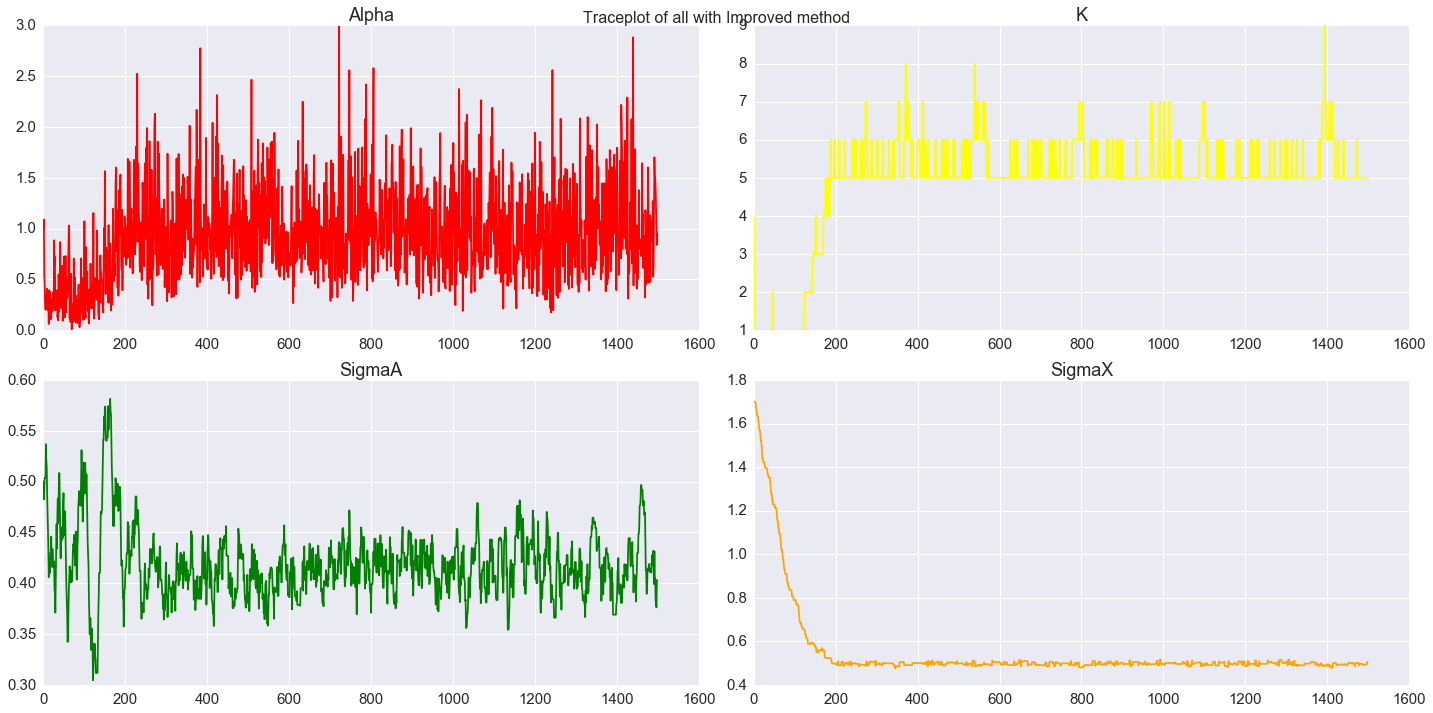

In [4]:
fig, axes = plt.subplots(2,2,figsize=(20,10))
plt.suptitle("Traceplot of all with Improved method", size=16)            
axes[0,0].plot(chain_1_Alpha,color='red')
axes[0,0].set_title("Alpha")
axes[0,1].plot(chain_1_K,color='yellow')
axes[0,1].set_title("K")
axes[1,0].plot(chain_1_SigmaA,color='green')
axes[1,0].set_title("SigmaA")
axes[1,1].plot(chain_1_SigmaX,color='orange')
axes[1,1].set_title("SigmaX")
fig.tight_layout()

To check the authenticity of our implementation, we first plot the results from the original sampler. We can see that K converges and oscillates between 5 and 6. Futhermore, $\sigma_X$ also converges to the true value of 0.5. With all of these parameters converging to the desired values, we can say that our implementation of the algorithm is successful. 

In [5]:
chain_1_Alpha = np.load("data/chain1/chain1Alpha.npy")
chain_1_K = np.load("data/chain1/chain1K.npy")
chain_1_SigmaA = np.load("data/chain1/chain1SigmaA.npy")
chain_1_SigmaX = np.load("data/chain1/chain1SigmaX.npy")
chain_1_Z = np.load("data/chain1/chain1Z.npy")

big_A = np.load("data/A_initialized.npy")
big_X = np.load("data/X_initialized.npy")

In [6]:
BURN_IN = 200
niter=1500
N=big_A.shape[0]
D=big_A.shape[1]
X_new=np.zeros((N,D))
Z = chain_1_Z[-1,:,:]
Z=Z[:,0:4]
sigma_X=np.mean(chain_1_SigmaX[BURN_IN:niter])
sigma_A=np.mean(chain_1_SigmaA[BURN_IN:niter])
A_inf=np.dot(np.dot(np.linalg.inv((np.dot(Z.T,Z)+(sigma_X/sigma_A)*np.eye(4))),Z.T),big_X)

for i in range(N):
    X_new[i,:]=np.dot(Z[i,:],A_inf[0:4,])

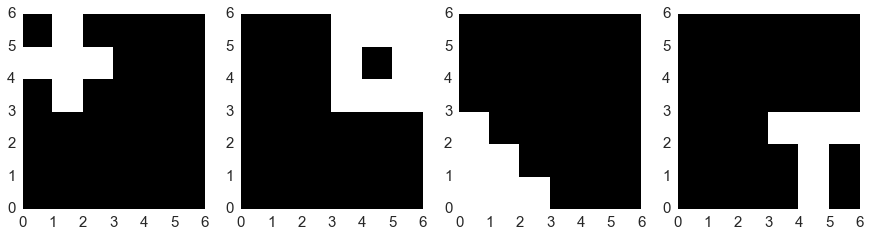

In [7]:
#Initial plots
plt.figure(num=None, figsize=(15,3.5), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(big_A[0,:].reshape(6,6),cmap=plt.cm.gray)     
plt.subplot(142)
plt.pcolormesh(big_A[1,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(143)
plt.pcolormesh(big_A[2,:].reshape(6,6),cmap=plt.cm.gray)  
plt.subplot(144)
plt.pcolormesh(big_A[3,:].reshape(6,6),cmap=plt.cm.gray) 
pass

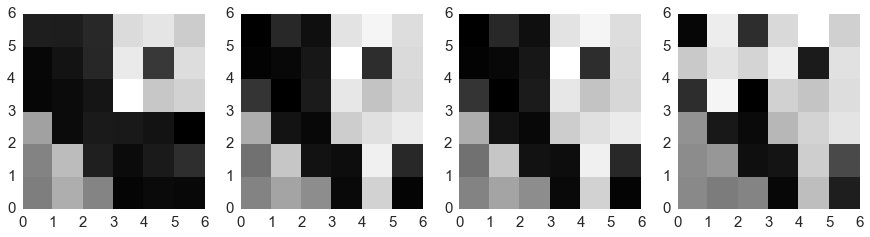

In [9]:
plt.figure(num=None, figsize=(15,3.5), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(141)
plt.pcolormesh(X_new[0,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(142)
plt.pcolormesh(X_new[1,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(143)
plt.pcolormesh(X_new[2,:].reshape(6,6),cmap=plt.cm.gray)
plt.subplot(144)
plt.pcolormesh(X_new[3,:].reshape(6,6),cmap=plt.cm.gray)
pass

We have tried to recreate X with the help of the posterior estimate of A from the formula:

$E(A\mid X,Z)= (Z^T Z+\frac{\sigma^2_X}{\sigma^2_A}I)^{-1}Z^TX$.

All of the related parameters are from the sampler results with 1500 iterations and 200 burn-in. From the plot we can see that the recreated objects can well identify the latent features. From left to right, the images indicates: 0110, 0111, 0111, 1111. Since it can have this effect, we can prove that we have implemented the algorithm successfully.


## 3. Optimization

To optimize the code and make the code run faster, we have tried to take advantage of the following methods as candidates and compare the efficiency among them. The possible options are Parallization, JIT, Cython, and an improving method in some function. These optimization techniques are compared by the time they consume. Before this, we have also tested the validity of the methods by checking trace plots.

### 3.1 Matrix Inverse


Inspired by the formulas (23) and (24) in Griffiths and Ghahramani's[1] paper, we also tried to use the method to calculate inverse as below:

$M_{-i}=(M^{-1}-z_i^T z_i)^{-1}=M-\frac{M z_i^T z_i M}{z_i M z_i^T -1}$  (23)

$M=(M^{-1}_{-i}+z_i^T z_i)^{-1}=M_{-i}-\frac{M_{-i}} {z_i^T z_i M_{-i}}{z_i M_{-i} z_i^T + 1}$  (24)

In [50]:
%%file scripts/compare_matrix_inverse.py
from original_functions import IBP_prior, calcInverse
import numpy as np
import time
#check whether the inversion method described by Griffiths and Ghahramani(2005) works
X=np.load('data/X_initialized.npy')
N=X.shape[0]
D=X.shape[1]
sigmaX=1.
sigmaA=1.
alpha=1.
i=2
k=1
Z,K = IBP_prior(alpha,N)
M = np.linalg.inv(Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K))
Z[i,k] = 1 - Z[i,k]
loops = 1000
t_calculate_inverse = np.zeros(loops)
for l in range(loops):
    t0=time.time()
    calcInverse(Z,M,i,k)
    t1=time.time()
    t_calculate_inverse[l]=t1-t0
mean_t_calculate_inverse = round(np.mean(t_calculate_inverse),7)


t_linalg_inverse = np.zeros(loops)
for l in range(loops):
    t0=time.time()
    np.linalg.inv(Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K))
    t1=time.time()
    t_linalg_inverse[l]=t1-t0
mean_t_linalg_inverse= round(np.mean(t_linalg_inverse),7)


aaaa = calcInverse(Z,M,i,k)
bbbb = np.linalg.inv(Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K))

results = np.array([aaaa,bbbb,mean_t_calculate_inverse,t_linalg_inverse])
np.save("data/inverse_compare_results",results)

Writing scripts/compare_matrix_inverse.py


In [25]:
import numpy.testing as npt
results = np.load("data/inverse_compare_results.npy")
# There are small portion of times that they don't almost equal
npt.assert_almost_equal(results[0],results[1], decimal =2)

In [26]:
import pandas as pd
columns = ['Time']
index = ['calcInverse','linear algebra inverse']
times = results[2:4]
df = pd.DataFrame(times,columns=columns,index=index)
df

,Time
calcInverse,1.7e-05
linear algebra inverse,3e-05


We can see from the table that calcInverse function is only using half of the time of np.linalg.inv, which is a great improvement when only updating one element of the matrix. However, since we are under MCMC setting, to reach a stationery distribution we need to run plenty of times, which will lead to accumulated numeric error.

### 3.2 Improve Likelihood

By looking deep into the original likelihood function, we can see that np.linalg.inv is actually being used twice, so we can probably save sometime by assigning the value to a temporary variable before using it to calculate the likelihood.

To be clear, in the original_functions.py, we have already define this improved log likelihood function called log_p, while log_p_origin represents the original unrevised log likelihood function.

### 3.3 Parallelization

Under MCMC setting we can't intuitively implement Parallelization because it's a Markov chain that we are updating. But using parallization is worth trying and can be validated by spliting the chain into multiple chains and combining them together after convergence. However, the processes might not turn out to be satisfying since we will be throwing out altogether more burn-ins. 

### 3.4 Cython

Cythonizing the code could be another way to speed up the code. First cythonize the functions, including IBP prior and the improved log likelihood function(log_p), and then cythonize the sampler.

In [32]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


#### Cythonize the functions (IBP_prior, log_p)

In [33]:
%%file Cython/Cython_functions.pyx
import numpy as np

cimport numpy as np

def IBP_prior(double alpha, int N):
    cdef double p
    cdef int i,j,K_plus,temp
    cdef np.ndarray res
    
    res = np.zeros((N, 1000))
    
    temp = np.random.poisson(alpha)
    if temp>0:
        res[0,0:temp] = np.ones(temp)

    K_plus = temp
    for i in range(1,N):
        for j in range(K_plus):
            p = np.sum(res[0:i,j])/(i+1)
            if np.random.uniform(0,1) < p:
                res[i,j] = 1
        temp = np.random.poisson(alpha/(i+1))
        if temp > 0:
            res[i, K_plus : K_plus + temp] = np.ones(temp)
            K_plus = K_plus + temp
    
    res = res[:,0:K_plus]
    return np.array((res, K_plus))

#log p(X|Z,σ_x ,σ_A )
def log_p(X, Z, double sigmaX, double sigmaA, int K, int D, int N):
    M = Z.T.dot(Z)+(sigmaX**2/sigmaA**2)*np.identity(K)
    return (-0.5)*N*D*np.log(2*np.pi) - (N-K)*D*np.log(sigmaX) - K*D*np.log(sigmaA) -0.5*D*np.log(np.linalg.det(M)) -0.5/(sigmaX**2)*np.trace((X.T.dot(np.identity(N)-Z.dot(np.linalg.inv(M).dot(Z.T)))).dot(X))

Overwriting Cython/Cython_functions.pyx


In [34]:
%%file Cython/Cython_setup.py

from distutils.core import setup, Extension
from Cython.Build import cythonize
import numpy as np

ext = Extension("Cython_functions",
                sources=["Cython/Cython_functions.pyx"],
                include_dirs=[np.get_include()],
                libraries=["m"],
                extra_compile_args=["-w",  "-std=c99"])

setup(name = "Cy_Funcs",
      ext_modules = cythonize(ext),
     include_dirs=[np.get_include()])

Overwriting Cython/Cython_setup.py


In [35]:
! python Cython/Cython_setup.py clean
! python Cython/Cython_setup.py -q build_ext --inplace

Compiling Cython/Cython_functions.pyx because it changed.
[1/1] Cythonizing Cython/Cython_functions.pyx
running clean
removing 'build/temp.macosx-10.5-x86_64-3.5' (and everything under it)
removing 'build'


#### Cythonize the sampler

In [36]:
%%file Cython/Cython_sampler.pyx
import numpy as np
cimport numpy as np
import math
import Cython_functions as func
def cy_sampler(double[:,:] X, int niter, double sigmaX, double sigmaA, double alpha, int N, int D, int maxNew):

    
    #initialization
    cdef int count=0
    cdef int j,i,kNew,kk,new,k
    cdef double[:,:] Z
    cdef double Log_L1,temp_unif
    cdef double Harmonic_N,alphaN, lik, pois, p
    cdef double temp_unif1, Log_L_New, sigmaX_a, U, sigmaA_new,sigmaX_new


    final_Z=np.zeros((niter,N,20))
    final_K=np.zeros((niter,1))
    final_sigma_X=np.zeros((niter,1))
    final_sigma_A=np.zeros((niter,1))
    final_alpha=np.zeros((niter,1))
    Z, Kplus = func.IBP_prior(alpha, N)
    
    #repeat "niter" number of times
    for j in range(niter):
        final_Z[count,:,0:Kplus] = Z
        final_K[count] = Kplus
        final_sigma_X[count] = sigmaX
        final_sigma_A[count] = sigmaA
        final_alpha[count] = alpha
        count = count + 1

        for i in range(N):
            for k in range(Kplus):
                if k >= Kplus:
                    break     
                if Z[i,k] > 0:
                    if (np.sum(Z[:,k])- 1) <= 0:
                        Z[:,k:(Kplus-1)] = Z[:,(k+1):Kplus]
                        Kplus = Kplus-1
                        Z = Z[:,0:Kplus]
                        continue
           

           #M-H algorithm for Z
                P = np.zeros(2)
                #set Z[i,k] = 0 and calculate posterior probability
                Z[i,k] = 0
                P[0] = func.log_p(X, Z, sigmaX, sigmaA, Kplus, D, N) + np.log(N-np.sum(Z[:,k])) - np.log(N)
                #set Z[i,k] = 1 and calculate posterior probability
                Z[i,k] = 1
                P[1] = func.log_p(X, Z,sigmaX, sigmaA, Kplus, D, N)  + np.log(np.sum(Z[:,k])- 1) - np.log(N)

                P = np.exp(P - max(P))
                U = np.random.uniform(0,1)
                if U<(P[1]/(np.sum(P))):
                    Z[i,k] = 1
                else:
                    Z[i,k] = 0   
  

            #M-H algorithm for k
            # Set the number of upper bound as 3
            maxNew = 3
            #Sample number of new features
            prob = np.zeros(maxNew)
            alphaN = alpha/N     
            for kNew in range(maxNew):
                Z_temp = Z
                if kNew > 0:
                    addCols = np.zeros((N,kNew))
                    addCols[i,:] = 1
                    Z_temp = np.hstack((Z_temp, addCols))

                pois = kNew*np.log(alphaN) - alphaN - np.log(math.factorial(kNew))
                kk = Kplus+kNew
                lik = func.log_p(X, Z_temp, sigmaX, sigmaA, kk, D, N)
                prob[kNew] = pois + lik
            prob = np.exp(prob - max(prob))
            prob = prob/sum(prob)

            U = np.random.uniform(0,1)
            p = 0
            kNew=0
            for new in range(maxNew):
                p = p + prob[new]
                if U < p:
                    kNew = new
                    break
            if kNew > 0:
                addCols = np.zeros((N,kNew))
                addCols[i,:] = 1
                Z = np.hstack((Z, addCols))
            Kplus = Kplus + kNew 
        Log_L1 = func.log_p(X, Z, sigmaX, sigmaA, Kplus, D, N )


        #update sigmaX  
        temp_unif = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaX_new = sigmaX - temp_unif
        else:
            sigmaX_new = sigmaX + temp_unif
    
        Log_L_New = func.log_p(X, Z, sigmaX_new, sigmaA, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))       
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaX = sigmaX_new


        #update sigmaA
        temp_unif1 = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaA_new = sigmaA - temp_unif1
        else:
            sigmaA_new = sigmaA + temp_unif1
    
        Log_L_New = func.log_p(X, Z, sigmaX, sigmaA_new, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaA = sigmaA_new
        

        #update alpha
        Harmonic_N = 0.
        for i in range(1, N+1):
            Harmonic_N += 1.0/i
        alpha = np.random.gamma(1+Kplus, 1/(1+Harmonic_N))  
 
    return(final_Z, final_K, final_sigma_A, final_sigma_X, final_alpha, Z)

Overwriting Cython/Cython_sampler.pyx


In [37]:
%%file Cython/Cython_setup_sampler.py

from distutils.core import setup, Extension
from Cython.Build import cythonize
import numpy as np

ext = Extension("Cython_sampler",
                sources=["Cython/Cython_sampler.pyx"],
                include_dirs=[np.get_include()],
                libraries=["m"],
                extra_compile_args=["-w",  "-std=c99"])

setup(name = "Cy_sampler",
      ext_modules = cythonize(ext),
     include_dirs=[np.get_include()])

Overwriting Cython/Cython_setup_sampler.py


In [38]:
! python Cython/Cython_setup_sampler.py clean
! python Cython/Cython_setup_sampler.py -q build_ext --inplace

Compiling Cython/Cython_sampler.pyx because it changed.
[1/1] Cythonizing Cython/Cython_sampler.pyx
running clean
removing 'build/temp.macosx-10.5-x86_64-3.5' (and everything under it)
removing 'build'


Before conducting optimization, we first test whether the code above works and give up a desired result similar to that in the paper. As is set in the paper: "The Gibbs sampler was initialized with K+ = 1, choosing the feature assignments for the first column by setting $z_{i1}$ = 1 with probability 0.5. $\sigma_A$, $\sigma_X$ , and $\alpha$ were initially set to 0.5, 1.7, and 1 respectively". To get a trace plot, parameters $\alpha$, $\sigma_A$ and $\sigma_X$ are sampled over 1500 iterations with 200 burn-in.

#### Compare samplers

In [48]:
%%file scripts/compare_sampler.py
import time
import numpy as np
from Cython_sampler import cy_sampler
import math
import Cython_functions as func
from Original_sampler import sampler
from gibbs_sampler import Update_Z,Update_Kplus,Update_sigmaX,Update_sigmaA,Update_alpha
from original_functions import log_p, log_p_origin, IBP_prior
X=np.load('data/X_initialized.npy')
niter = 1500
N = 100 
D = 36 
sigmaX = 1.7
sigmaA = 0.5
alpha = 1.0
maxNew = 4
BURN_IN=200
SAMPLE_SIZE= niter-BURN_IN
np.random.seed(124)
t0=time.time()
chain1_Z, chain1_K, chain1_sigma_A, chain1_sigma_X, chain1_alpha, Z1= sampler(X, niter, sigmaX, sigmaA, alpha, N, D, maxNew, log_p_origin)  
t1=time.time()-t0

np.save("data/chain1/chain1Z", chain1_Z)
np.save("data/chain1/chain1K",chain1_K)
np.save("data/chain1/chain1SigmaX", chain1_sigma_X)
np.save("data/chain1/chain1SigmaA",chain1_sigma_A)
np.save("data/chain1/chain1Alpha", chain1_alpha) 
np.random.seed(124)
t0=time.time()
chain2_Z, chain2_K, chain2_sigma_A, chain2_sigma_X, chain2_alpha, Z2= sampler(X, niter, sigmaX, sigmaA, alpha, N, D, maxNew, log_p)  
t2=time.time()-t0

np.save("data/chain2/chain2Z", chain2_Z)
np.save("data/chain2/chain2K",chain2_K)
np.save("data/chain2/chain2SigmaX", chain2_sigma_X)
np.save("data/chain2/chain2SigmaA",chain2_sigma_A)
np.save("data/chain2/chain2Alpha", chain2_alpha) 
np.random.seed(124)
t0=time.time()
chain3_Z, chain3_K, chain3_sigma_A, chain3_sigma_X, chain3_alpha, Z3= cy_sampler(X, niter, sigmaX, sigmaA, alpha, N, D, maxNew)  
t3=time.time()-t0

np.save("data/chain3/chain3Z", chain3_Z)
np.save("data/chain3/chain3K",chain3_K)
np.save("data/chain3/chain3SigmaX", chain3_sigma_X)
np.save("data/chain3/chain3SigmaA",chain3_sigma_A)
np.save("data/chain3/chain3Alpha", chain3_alpha) 

np.save("data/sampler_time", np.array([t1,t2,t3]))

Writing scripts/compare_sampler.py


In [27]:
import pandas as pd
times = np.load("data/sampler_time.npy")
columns = ['Time(s)']
index = ['sampler_original_likelihood','sampler_improved_likelihood','Cythonized_sampler_improved_likelihood']
df = pd.DataFrame(times,columns=columns,index=index)
df

,Time(s)
sampler_original_likelihood,343.168945
sampler_improved_likelihood,316.431679
Cythonized_sampler_improved_likelihood,302.441189


The table is telling us that Cythonizing the code is helping us improve the performance of the code, while improved likelihood has also given us a great optimization.

### 3.5 JIT

In [23]:
from numba import jit
import numpy as np
import math

In [24]:
@jit

def numba_sampler(X, niter, sigmaX, sigmaA, alpha, N, D, maxNew, log_p):

    
    #initialization
    count=0
    final_Z=np.zeros((niter,N,20))
    final_K=np.zeros((niter,1))
    final_sigma_X=np.zeros((niter,1))
    final_sigma_A=np.zeros((niter,1))
    final_alpha=np.zeros((niter,1))
    Z, Kplus = IBP_prior(alpha, N)
    
    #repeat "niter" number of times
    for j in range(niter):
        final_Z[count,:,0:Kplus] = Z
        final_K[count] = Kplus
        final_sigma_X[count] = sigmaX
        final_sigma_A[count] = sigmaA
        final_alpha[count] = alpha
        count = count + 1

        for i in range(N):
            for k in range(Kplus):
                if k >= Kplus:
                    break     
                if Z[i,k] > 0:
                    if (np.sum(Z[:,k])- 1) <= 0:
                        Z[:,k:(Kplus-1)] = Z[:,(k+1):Kplus]
                        Kplus = Kplus-1
                        Z = Z[:,0:Kplus]
                        continue
           

           #M-H algorithm for Z
                P = np.zeros(2)
                #set Z[i,k] = 0 and calculate posterior probability
                Z[i,k] = 0
                P[0] = log_p(X, Z, sigmaX, sigmaA, Kplus, D, N) + np.log(N-np.sum(Z[:,k])) - np.log(N)
                #set Z[i,k] = 1 and calculate posterior probability
                Z[i,k] = 1
                P[1] = log_p(X, Z,sigmaX, sigmaA, Kplus, D, N)  + np.log(np.sum(Z[:,k])- 1) - np.log(N)

                P = np.exp(P - max(P))
                U = np.random.uniform(0,1)
                if U<(P[1]/(np.sum(P))):
                    Z[i,k] = 1
                else:
                    Z[i,k] = 0   
  

            #M-H algorithm for k
            # Set the number of upper bound as 3
            maxNew = 3
            #Sample number of new features
            prob = np.zeros(maxNew)
            alphaN = alpha/N     
            for kNew in range(maxNew):
                Z_temp = Z
                if kNew > 0:
                    addCols = np.zeros((N,kNew))
                    addCols[i,:] = 1
                    Z_temp = np.hstack((Z_temp, addCols))

                pois = kNew*np.log(alphaN) - alphaN - np.log(math.factorial(kNew))
                kk = Kplus+kNew
                lik = log_p(X, Z_temp, sigmaX, sigmaA, kk, D, N)
                prob[kNew] = pois + lik
            prob = np.exp(prob - max(prob))
            prob = prob/sum(prob)

            U = np.random.uniform(0,1)
            p = 0
            kNew=0
            for new in range(maxNew):
                p = p + prob[new]
                if U < p:
                    kNew = new
                    break
            if kNew > 0:
                addCols = np.zeros((N,kNew))
                addCols[i,:] = 1
                Z = np.hstack((Z, addCols))
            Kplus = Kplus + kNew 
        Log_L1 = log_p(X, Z, sigmaX, sigmaA, Kplus, D, N )


        #update sigmaX  
        temp_unif = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaX_new = sigmaX - temp_unif
        else:
            sigmaX_new = sigmaX + temp_unif
    
        Log_L_New = log_p(X, Z, sigmaX_new, sigmaA, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))       
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaX = sigmaX_new


        #update sigmaA
        temp_unif1 = np.random.uniform(0,1)/30
        if np.random.uniform(0,1) < .5:
            sigmaA_new = sigmaA - temp_unif1
        else:
            sigmaA_new = sigmaA + temp_unif1
    
        Log_L_New = log_p(X, Z, sigmaX, sigmaA_new, Kplus, D, N)
        sigmaX_a = np.exp(min(0,Log_L_New-Log_L1))
        U = np.random.uniform(0,1)
        if U < sigmaX_a:
            sigmaA = sigmaA_new
        

        #update alpha
        Harmonic_N = 0.
        for i in range(1, N+1):
            Harmonic_N += 1.0/i
        alpha = np.random.gamma(1+Kplus, 1/(1+Harmonic_N))  
 
    return(final_Z, final_K, final_sigma_A, final_sigma_X, final_alpha, Z)

In [49]:
%%file scripts/compare_jit_with_original
import time
X=np.load('data/X_initialized.npy')
niter = 1500
N = 100 
D = 36 
sigmaX = 1.7
sigmaA = 0.5
alpha = 1.0
maxNew = 4
BURN_IN=200
SAMPLE_SIZE= niter-BURN_IN
np.random.seed(124)
t0 = time.time()
chain4_Z, chain4_K, chain4_sigma_A, chain4_sigma_X, chain4_alpha, Z4 = numba_sampler(X, niter, sigmaX, sigmaA, alpha, N, D, maxNew, log_p_origin)
t4 = time.time()-t0
np.save("data/chain4/chain4Z", chain4_Z)
np.save("data/chain4/chain4K",chain4_K)
np.save("data/chain4/chain4SigmaX", chain4_sigma_X)
np.save("data/chain4/chain4SigmaA",chain4_sigma_A)
np.save("data/chain4/chain4Alpha", chain4_alpha) 
np.save("data/jit_time",t4)

Writing scripts/compare_jit_with_original


In [36]:
import pandas as pd
times = np.load("data/sampler_time.npy")
jit_time = np.load("data/jit_time.npy")
columns = ['Time(s)']
index = ['sampler_original_likelihood','sampler_improved_likelihood','Cythonized_sampler','jit_original-likelihood']
df = pd.DataFrame(np.array([times[0],times[1],times[2],jit_time]),columns=columns,index=index)
df

,Time(s)
sampler_original_likelihood,343.168945
sampler_improved_likelihood,316.431679
Cythonized_sampler,302.441189
jit_original-likelihood,400.117821


By comparing the numbers in the table, we can see that from the perspective of code performance:

jit_origina-likelihood < sampler_original_likelihood < sampler_improved_likelihood < Cythonized_sampler

We can conclude from this formula that JIT is not giving us a better but worse performance, while Cython is slightly better when being used.

JIT is generally good at speeding up straight-forward Python code that spends a lot of time in the bytecode dispatch loop, i.e., running actual Python code – as opposed to running things that only are invoked by Python code. When the JIT cannot help, we could use Cython.

## 4. Conclusions

In [38]:
chain_1 = np.load("data/chain1/chain1SigmaX.npy")
chain_2 = np.load("data/chain2/chain2SigmaX.npy")
chain_3 = np.load("data/chain3/chain3SigmaX.npy")
chain_4 = np.load("data/chain4/chain4SigmaX.npy")

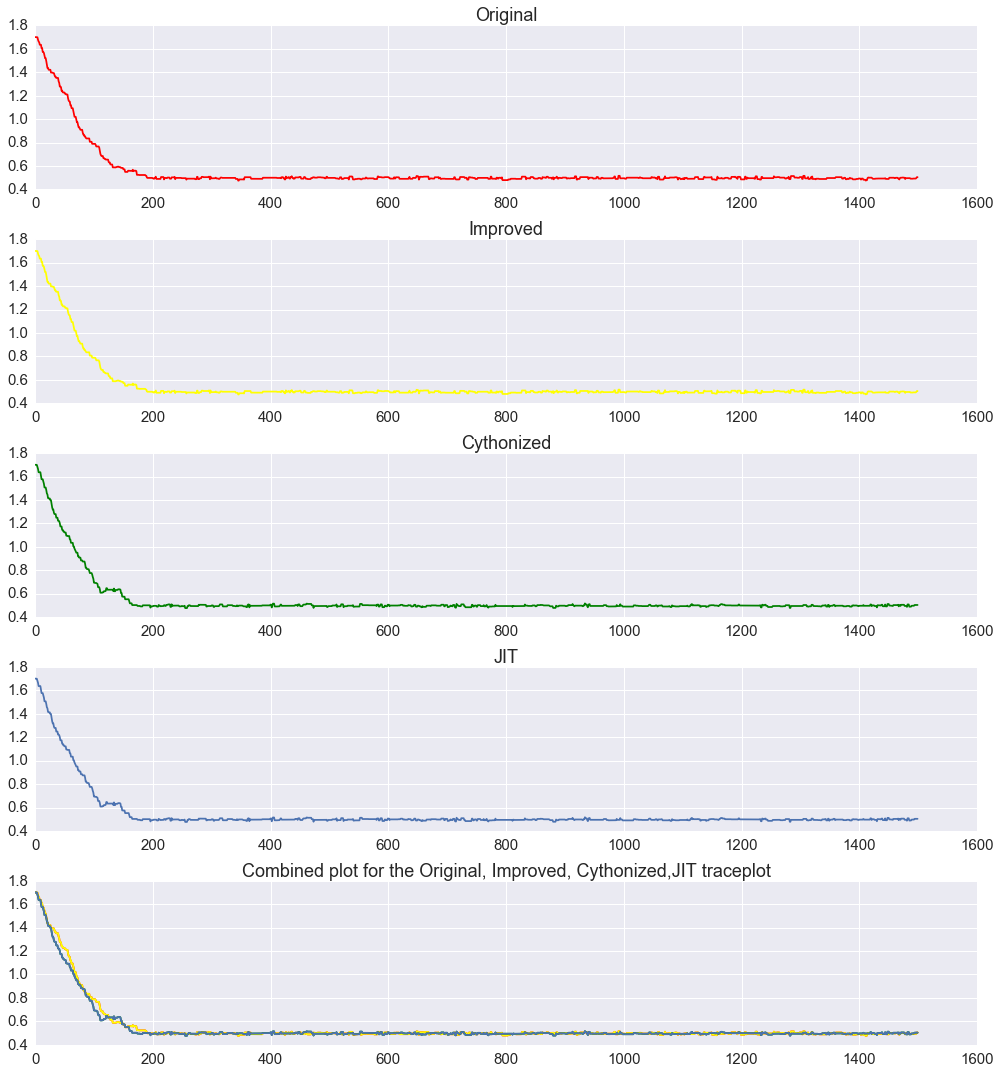

In [42]:
fig, axes = plt.subplots(5,1,figsize=(14,15))

axes[0].plot(chain_1,color='red',label="aaa")
axes[0].set_title("Original")
axes[1].plot(chain_2,color='yellow', label='Line 2')
axes[1].set_title("Improved")
axes[2].plot(chain_3,color='green')
axes[2].set_title("Cythonized")
axes[3].plot(chain_4)
axes[3].set_title("JIT")
axes[4].plot(chain_1,color='red')
axes[4].plot(chain_2,color='yellow')
axes[4].plot(chain_3,color='green')
axes[4].plot(chain_4)
axes[4].set_title("Combined plot for the Original, Improved, Cythonized,JIT traceplot")
axes[4].legend
fig.tight_layout()

We have run the original sampler, the improved sampler as well as the Cythonized sampler. All of these are done 1500 times and the traceplots for $\alpha$, K, $\sigma_A$ and $\sigma_X$. Here we used traceplot to check the authentication of the algorithm. For example, here the traceplots of $\sigma_X$ are all plotted and we can see that all of the them converge to the true value of 0.5.

We have successfully implementation the Indian Buffet Process and used it in the infinite binary feature model shown in the complete paper(Griffiths&Ghahramani, 2011). Since the original Gibbs and Metropolis-Hasting sampling using the results from the paper is quite time-consuming, our main effort lays in accelarating the program with various methods.


We managed to try out several speed up optimizations, and we have following findings:

   Matrix inverse could be successfully improved using the method raised in Griffiths' reference when we are only updating one element of a matrix, but there would be numerical error if we use this method plenty of times, especially in the case of MCMC. 

Parallelization is not feasible when interactng with MCMC directly but spliting the chain could be an optimization, though in this case it's not. 

JIT is not helping with the code performance, but Cython is able to speed up around 5% faster than not using Cython.

What speeds up most is the improved log likelihood function, which avoids multiple calculation of the same math function.

More work can be done in the future to help better improve both the algorithm and the code performance.

## References

[1] Griffiths, Thomas L., and Zoubin Ghahramani. "The indian buffet process: An introduction and review." The Journal of Machine Learning Research 12 (2011): 1185-1224.

[2] Ghahramani, Zoubin, and Thomas L. Griffiths. "Infinite latent feature models and the Indian buffet process." Advances in neural information processing systems. 2005.